In [1]:
#pip install pandas numpy matplotlib seaborn tensorflow scikit-learn

In [2]:
#Imports & Environment Check
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

2026-01-21 20:32:24.721717: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-21 20:32:24.735346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 20:32:25.216530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 20:32:27.902801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [3]:
# =========================
# Load Market Trend Dataset
# =========================

train_df = pd.read_csv("../../data/training_data.csv")
test_df  = pd.read_csv("../../data/test_data.csv")

print("Training shape:", train_df.shape)
print("Test shape:", test_df.shape)

# =========================
# Convert Date column to datetime & extract time features
# =========================
for df in [train_df, test_df]:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"]  = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"]   = df["Date"].dt.day
    df.drop(columns=["Date"], inplace=True)

train_df.head()


Training shape: (24000, 15)
Test shape: (6000, 15)


,Open_Price,Close_Price,High_Price,Low_Price,Volume,Daily_Return_Pct,Volatility_Range,VIX_Close,Economic_News_Flag,Sentiment_Score,Federal_Rate_Change_Flag,GeoPolitical_Risk_Score,Currency_Index,Close_Price_Normalized,Year,Month,Day
0,46.14,44.01,46.60,42.82,12834123,-4.6164,3.78,22.47,1,-0.544,1,8.71,92.11,0.331842,1986,1,23
1,79.41,79.52,80.64,78.10,3822946,0.1385,2.54,39.96,0,-0.332,0,55.43,97.66,0.605817,1903,8,25
2,37.88,37.11,38.25,37.07,5306690,-2.0327,1.18,44.40,0,0.962,1,44.54,82.79,0.278605,1990,8,14
3,60.87,61.44,61.55,59.28,15075128,0.9364,2.27,34.51,0,0.677,0,7.85,80.36,0.466322,1905,1,19
4,8.11,7.93,8.47,7.60,13982675,-2.2195,0.87,34.29,0,-0.296,0,67.17,107.15,0.053468,1968,3,11


In [4]:
# =========================
# Define target & features
# =========================

TARGET = "Close_Price"

# Date already removed earlier
DROP_COLS = []

X_train = train_df.drop(columns=DROP_COLS + [TARGET])
y_train = train_df[TARGET]

X_test  = test_df.drop(columns=DROP_COLS + [TARGET])
y_test  = test_df[TARGET]


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



X_train shape: (24000, 16)
y_train shape: (24000,)


In [5]:
from sklearn.preprocessing import StandardScaler

# Scale BOTH features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1,1))


In [6]:
# =========================
# Build ANN Model
# =========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

INPUT_DIM = X_train.shape[1]

model = Sequential([
    Dense(256, activation='relu',
          kernel_regularizer=l2(0.0005),
          input_shape=(INPUT_DIM,)),
    BatchNormalization(),
    Dropout(0.35),

    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.0007),
    loss='mse',
    metrics=['mae']
)

model.summary()




/home/aravi/miniconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-21 20:32:40.660132: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,105 (184.00 KB)

 Trainable params: 46,337 (181.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3249 - mae: 0.3566 - val_loss: 0.1169 - val_mae: 0.1086 - learning_rate: 7.0000e-04
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1759 - mae: 0.2237 - val_loss: 0.1020 - val_mae: 0.0917 - learning_rate: 7.0000e-04
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1426 - mae: 0.1914 - val_loss: 0.0910 - val_mae: 0.0977 - learning_rate: 7.0000e-04
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1214 - mae: 0.1780 - val_loss: 0.0713 - val_mae: 0.0781 - learning_rate: 7.0000e-04
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0962 - mae: 0.1610 - val_loss: 0.0522 - val_mae: 0.0645 - learning_rate: 7.0000e-04
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0761 - mae: 0.1504 - val_loss: 0.0507 - val_mae: 0.1141 - learning_rate: 7.0000e-04
Epoch 7/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0582 - mae: 0.1360 - val_loss: 0.0299 - val_mae: 0.0702

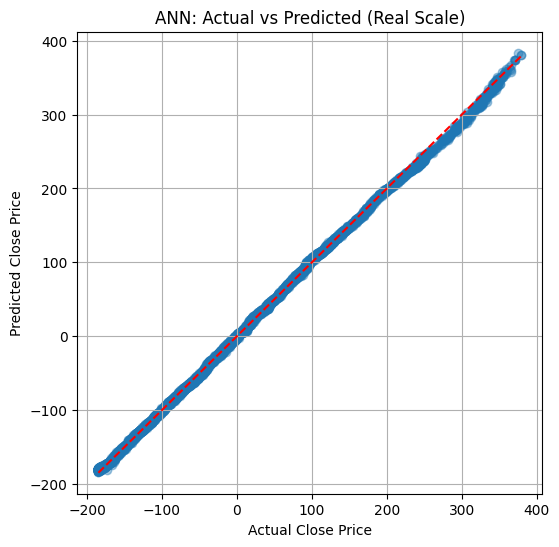

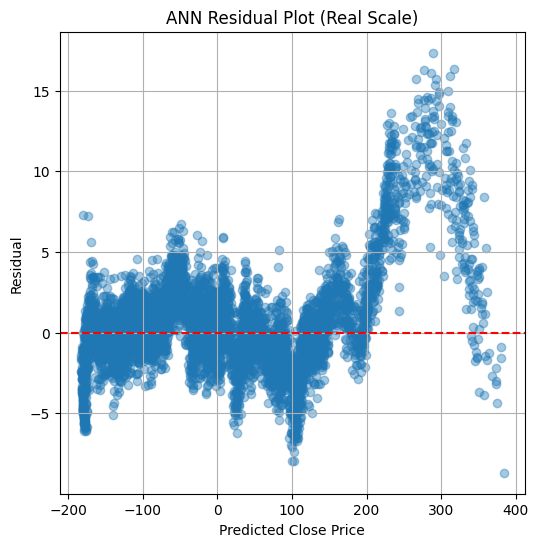

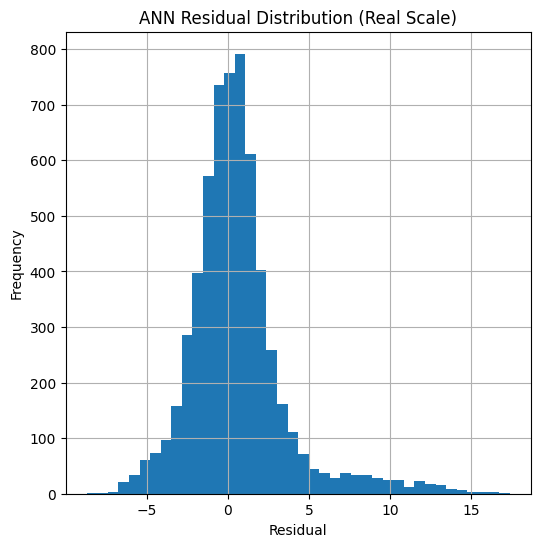

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Callbacks
# =========================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-5,
    verbose=1
)

# =========================
# Train Model
# =========================
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# =========================
# Predictions (normalized scale)
# =========================
y_pred = model.predict(X_test_scaled).flatten()
y_test_scaled = np.asarray(y_test_scaled).flatten()

# =========================
# Metrics (normalized scale)
# =========================
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
r2   = r2_score(y_test_scaled, y_pred)

print(f"ANN RMSE (normalized): {rmse:.6f}")
print(f"ANN R² (normalized): {r2:.6f}")

# =========================
# De-normalize for plotting (REAL SCALE)
# =========================
price_min = train_df["Close_Price"].min()
price_max = train_df["Close_Price"].max()

y_test_real = y_test_scaled * (price_max - price_min) + price_min
y_pred_real = y_pred * (price_max - price_min) + price_min

# --- Force perfect alignment (prevents plotting bug forever) ---
y_test_real = np.asarray(y_test_real).flatten()
y_pred_real = np.asarray(y_pred_real).flatten()

assert len(y_test_real) == len(y_pred_real)

residuals_real = y_test_real - y_pred_real

# =========================
# Actual vs Predicted Plot (REAL SCALE)
# =========================
plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.4)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], "r--")
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("ANN: Actual vs Predicted (Real Scale)")
plt.grid(True)
plt.show()

# =========================
# Residual Diagnostics (REAL SCALE)
# =========================
plt.figure(figsize=(6,6))
plt.scatter(y_pred_real, residuals_real, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Close Price")
plt.ylabel("Residual")
plt.title("ANN Residual Plot (Real Scale)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.hist(residuals_real, bins=40)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("ANN Residual Distribution (Real Scale)")
plt.grid(True)
plt.show()


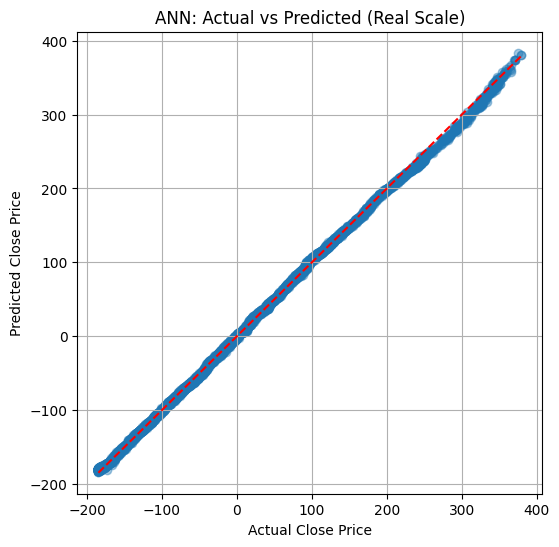

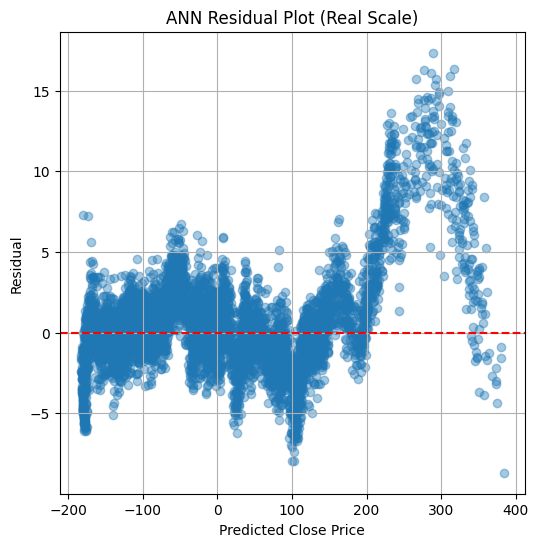

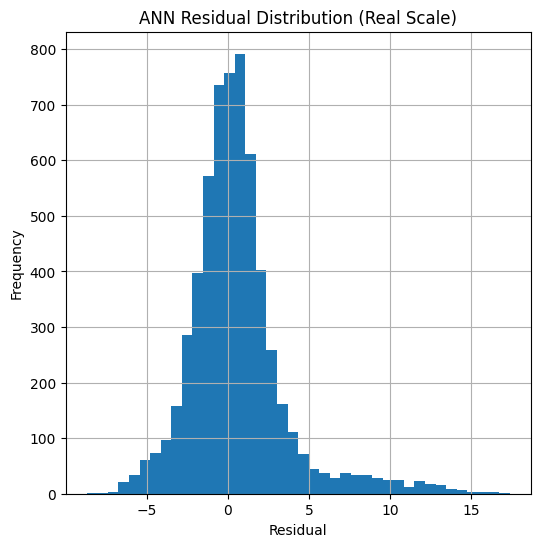

In [14]:
import os
import matplotlib.pyplot as plt

# =========================
# Output directory
# =========================
output_dir = "../../documentation/"
os.makedirs(output_dir, exist_ok=True)

# =========================
# Actual vs Predicted Plot (REAL SCALE)
# =========================
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred_real, alpha=0.4)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--"
)
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("ANN: Actual vs Predicted (Real Scale)")
plt.grid(True)

plt.savefig(
    os.path.join(output_dir, "ann_actual_vs_predicted_real.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# =========================
# Residual Diagnostics (REAL SCALE)
# =========================
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_real, residuals_real, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Close Price")
plt.ylabel("Residual")
plt.title("ANN Residual Plot (Real Scale)")
plt.grid(True)

plt.savefig(
    os.path.join(output_dir, "ann_residual_plot_real.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# =========================
# Residual Distribution (REAL SCALE)
# =========================
plt.figure(figsize=(6, 6))
plt.hist(residuals_real, bins=40)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("ANN Residual Distribution (Real Scale)")
plt.grid(True)

plt.savefig(
    os.path.join(output_dir, "ann_residual_distribution_real.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()


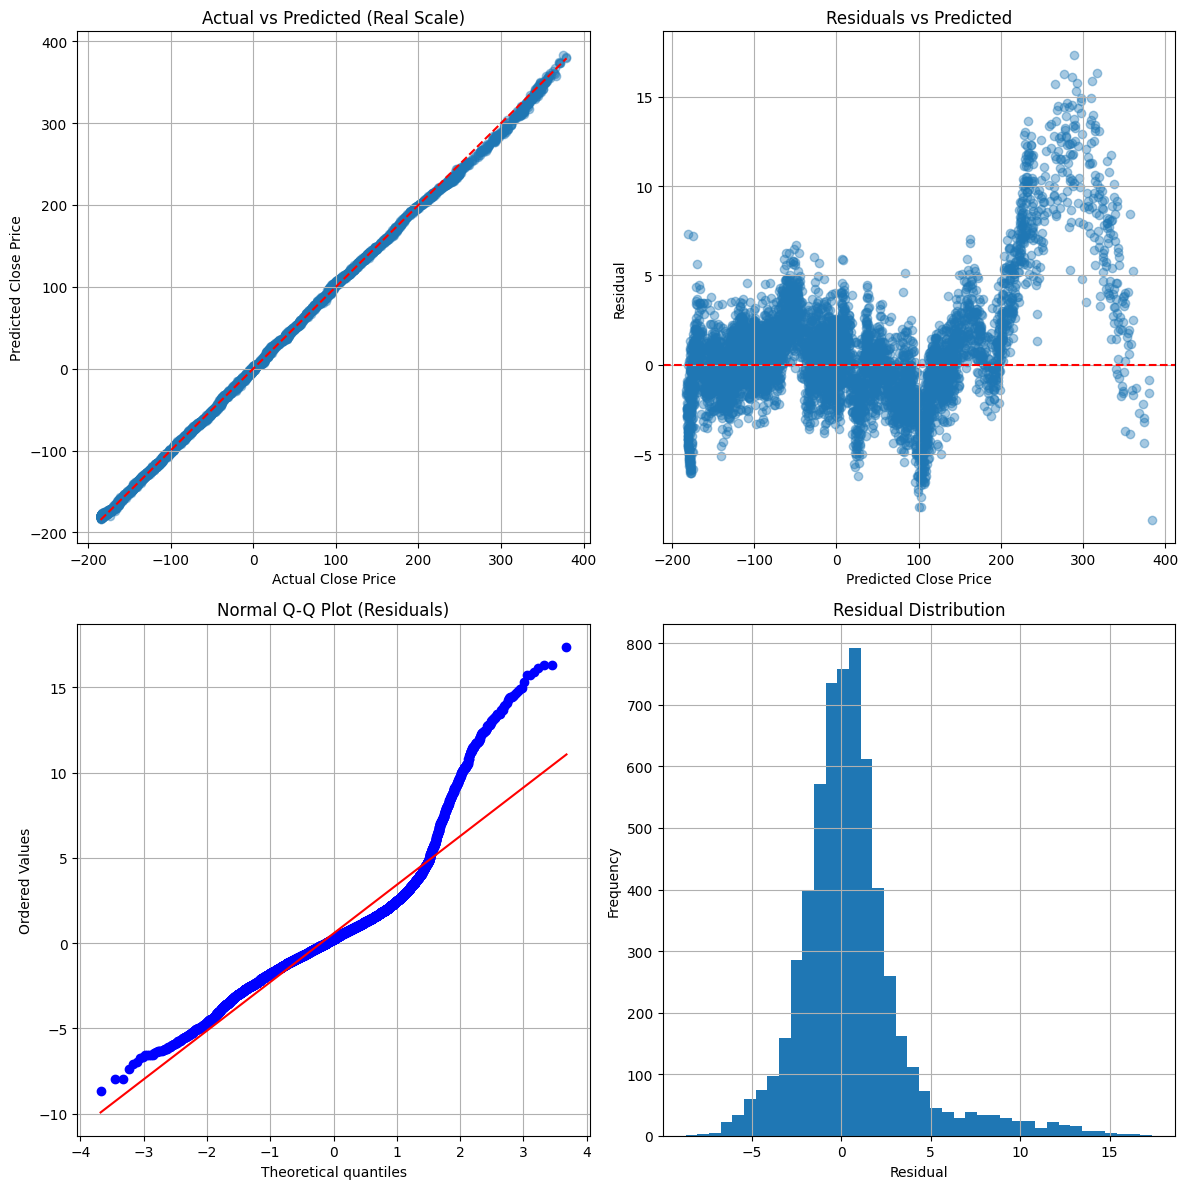

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# =========================
# Output directory
# =========================
output_dir = "../../documentation/"
os.makedirs(output_dir, exist_ok=True)

# =========================
# ANN Diagnostics Data
# =========================
residuals = residuals_real
predicted = y_pred_real

# =========================
# Create 2x2 diagnostic figure
# =========================
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# ---- 1. Actual vs Predicted ----
axes[0, 0].scatter(y_test_real, predicted, alpha=0.4)
axes[0, 0].plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--"
)
axes[0, 0].set_title("Actual vs Predicted (Real Scale)")
axes[0, 0].set_xlabel("Actual Close Price")
axes[0, 0].set_ylabel("Predicted Close Price")
axes[0, 0].grid(True)

# ---- 2. Residuals vs Predicted ----
axes[0, 1].scatter(predicted, residuals, alpha=0.4)
axes[0, 1].axhline(0, color="red", linestyle="--")
axes[0, 1].set_title("Residuals vs Predicted")
axes[0, 1].set_xlabel("Predicted Close Price")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].grid(True)

# ---- 3. Normal Q-Q Plot (Residuals) ----
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Normal Q-Q Plot (Residuals)")
axes[1, 0].grid(True)

# ---- 4. Residual Distribution ----
axes[1, 1].hist(residuals, bins=40)
axes[1, 1].set_title("Residual Distribution")
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True)

# =========================
# Save combined diagnostics
# =========================
plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "ann_diagnostic_plots_combined.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [8]:

# =========================
# Predict
# =========================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()


# =========================
# Evaluate
# =========================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"ANN RMSE: {rmse:.4f}")
print(f"ANN R²: {r2:.4f}")



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
ANN RMSE: 0.6957
ANN R²: 0.9994


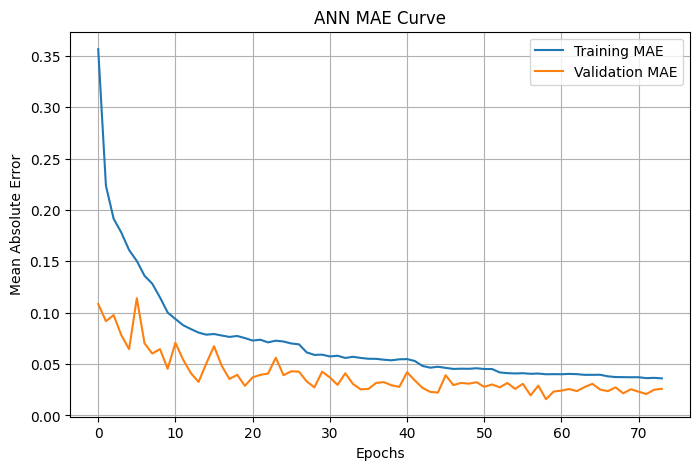

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("ANN MAE Curve")
plt.legend()
plt.grid(True)
plt.savefig("../../documentation/mae_curve.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [203]:
#Build ANN Model (TensorFlow)
# model = Sequential([
#     Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
#     Dense(32, activation="relu"),
#     Dense(1, activation="linear")
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss="mse",
#     metrics=["mae"]
# )

# model.summary()

In [204]:
#Train the Model
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=10,
#     restore_best_weights=True
# )

# history = model.fit(
#     X_train_scaled,
#     y_train,
#     validation_data=(X_test_scaled, y_test),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop],
#     verbose=1
# )

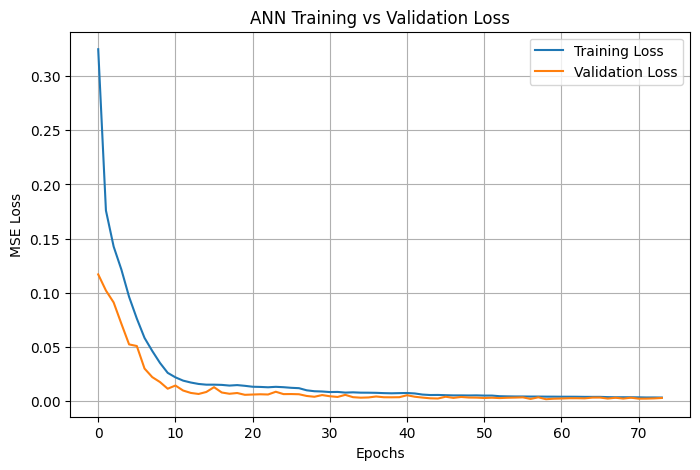

In [10]:
# Training & Validation Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("ANN Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("../../documentation/training_curve.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [206]:
# Save Trained ANN Model
MODEL_PATH = "code/models/currentAiSolution.h5"
model.save(MODEL_PATH)
print("Model saved.")


Model saved.


/Users/shashankkalaskar/miniconda3/envs/tf215/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
metrics_df = pd.DataFrame({
    "RMSE": [rmse],
    "R2": [r2],
    "Final_Train_Loss": [history.history["loss"][-1]],
    "Final_Val_Loss": [history.history["val_loss"][-1]]
})

metrics_df.to_csv("ann_metrics.csv", index=False)


In [12]:
# =========================
# Activation / Inference on New Market Data
# =========================

ACTIVATION_PATH = "../../data/activation_data.csv"
activation_df = pd.read_csv(ACTIVATION_PATH)

# Rebuild date features exactly like training
activation_df["Date"] = pd.to_datetime(activation_df["Date"])
activation_df["Year"]  = activation_df["Date"].dt.year
activation_df["Month"] = activation_df["Date"].dt.month
activation_df["Day"]   = activation_df["Date"].dt.day

# Build feature matrix exactly like training
X_activation = activation_df.drop(columns=["Date", "Close_Price"], errors="ignore")

# Align columns
X_activation = X_activation.reindex(columns=X_train.columns, fill_value=0)

# Scale activation features
X_activation_scaled = x_scaler.transform(X_activation)

# Predict in scaled space
y_activation_pred_scaled = model.predict(X_activation_scaled)

# Inverse-scale to real price
y_activation_pred = y_scaler.inverse_transform(y_activation_pred_scaled).flatten()

# Attach to dataframe
activation_df["Predicted_Close_Price"] = y_activation_pred

activation_df[["Close_Price", "Predicted_Close_Price"]].head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,Close_Price,Predicted_Close_Price
0,11.62,11.8118


In [13]:
import os

os.makedirs("code/models", exist_ok=True)


import joblib

joblib.dump(scaler, "code/models/scaler.pkl")
print("Scaler saved to code/models/scaler.pkl")



NameError: name 'scaler' is not defined